## Table of Contents
0. [Import Libraries](#0-import-libraries)  
1. [Import Data](#1-import-data)  
2. [Data Exploration](#2-data-exploration)  
3. [Data Cleaning](#3-data-cleaning)  
4. [Data Preparation](#4-data-preparation)  
5. [Benchmark Model](#5-benchmark-model)  
6. [Feature Engineering](#6-feature-engineering)  
7. [Model Training](#7-model-training)  
   7.1. [Decision Tree](#71-decision-tree)  
   7.2. [Random Forest](#72-random-forest)  
   7.3. [Gradient Boosting](#73-gradient-boosting)  
   7.4. [Comparing Algorithm Performances](#74-comparing-algorithm-performances)  
8. [Tuning](#8-tuning)  
9. [Bonus: Classification](#9-bonus-classification)  

# 0. Import Libraries
[Back to Top](#table-of-contents)

In [4]:
import pandas as pd
import numpy as np

%matplotlib inline

# 1. Import Data
[Back to Top](#table-of-contents)


Data is collected from: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

In [14]:
file_path = "/Users/fulyaakgun/Desktop/New-York-Taxi-Analysis/yellow_tripdata_2024-01.parquet"
taxi_jan_2024 = pd.read_parquet(file_path)

In [16]:
taxi_jan_2024.shape

(2964624, 19)

In [18]:
taxi_jan_2024.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [20]:
taxi_data = pd.concat([taxi_jan_2024])

# 2. Data Exploration
[Back to Top](#table-of-contents)


In [23]:
taxi_jan_2024.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee'],
      dtype='object')

In [62]:
taxi_jan_2024 = taxi_jan_2024[['tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID','PULocationID', 
       'DOLocationID', 'payment_type','total_amount']]

array([[<Axes: title={'center': 'tpep_pickup_datetime'}>,
        <Axes: title={'center': 'tpep_dropoff_datetime'}>,
        <Axes: title={'center': 'passenger_count'}>],
       [<Axes: title={'center': 'trip_distance'}>,
        <Axes: title={'center': 'RatecodeID'}>,
        <Axes: title={'center': 'PULocationID'}>],
       [<Axes: title={'center': 'DOLocationID'}>,
        <Axes: title={'center': 'payment_type'}>,
        <Axes: title={'center': 'total_amount'}>]], dtype=object)

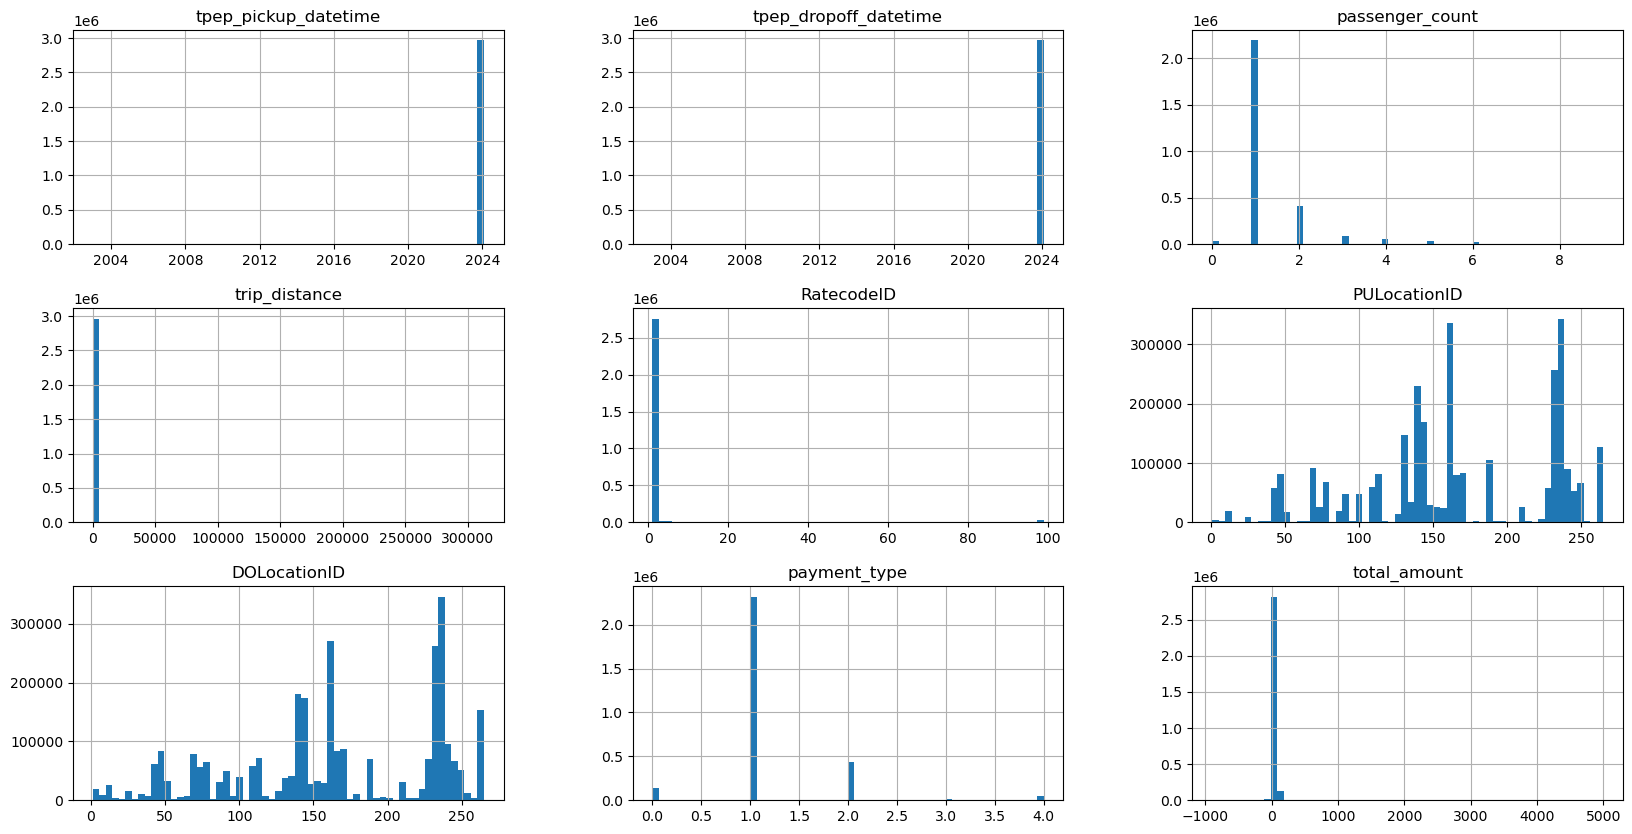

In [64]:
taxi_jan_2024.hist(figsize = (20,10) , bins =60)

### Histogram Explanation: 
According to data_dictionary_trip_records_yellow:</p>
Paymeny type - 1= Credit card ,2= Cash. Mostly credit card is used for trips. </p>
Trip distance is mainly very short</p>
Passenger count - mainly 1 people only</p>
Total Amount needs to be examined - very close to zero, also 600k for a taxi trip is suspcious</p>
RatecodeID - needs to be examined as well </p>
Note: if we only had data on close to zero histogram wouldn't show other parts. Even though with our eyes we can not see it, there are still data on these points! As you can see below:


In [67]:
taxi_jan_2024['RatecodeID'].value_counts() #RatecodeID is which area did the trip happen? 

RatecodeID
1.0     2663350
2.0       98713
99.0      28663
5.0       19410
3.0        7954
4.0        6365
6.0           7
Name: count, dtype: int64

<Axes: xlabel='index', ylabel='total_amount'>

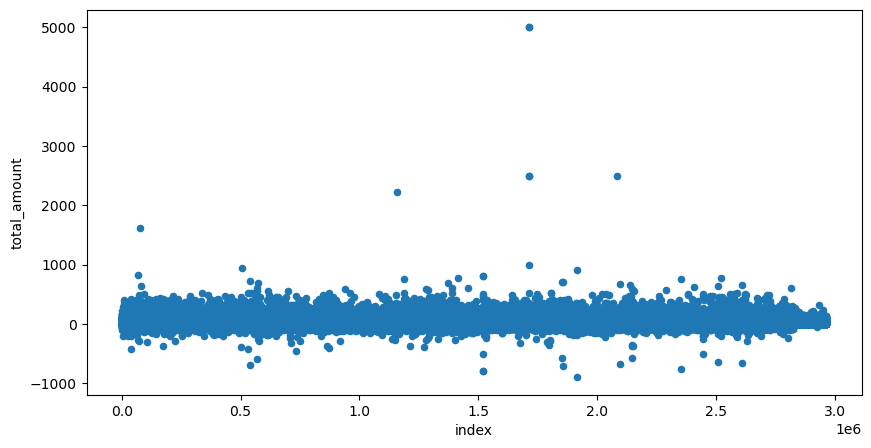

In [69]:
taxi_jan_2024.reset_index().plot(kind = 'scatter' , y = 'total_amount' , x = 'index' , figsize= (10,5))

Let's look at the values only under 100000

<Axes: xlabel='index', ylabel='total_amount'>

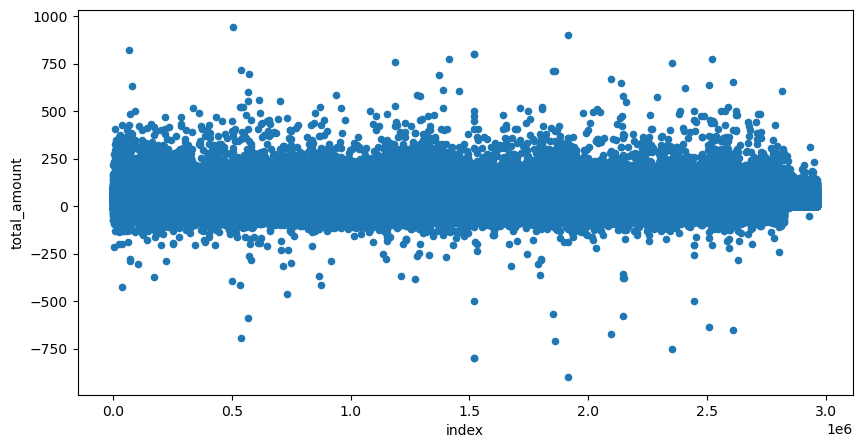

In [72]:
taxi_jan_2019[taxi_jan_2024['total_amount'] < 1000].reset_index().plot(kind = 'scatter' , y = 'total_amount' , x = 'index' , figsize= (10,5))

Majority of the total amount is around $1000 as expected. We have some extreme and negative values that we have to deal with!

### First look at the negative values:

In [76]:
taxi_jan_2024[taxi_jan_2024['total_amount'] < 0].shape

(35504, 9)

<Axes: xlabel='index', ylabel='total_amount'>

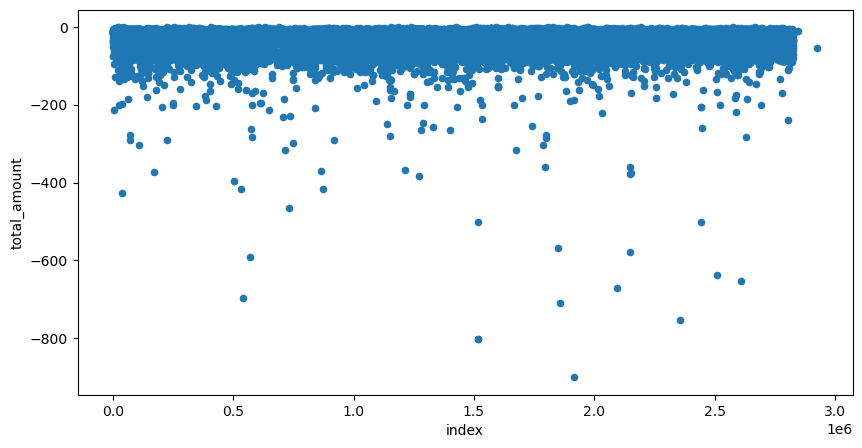

In [78]:
taxi_jan_2024[taxi_jan_2024['total_amount'] < 0].reset_index().plot(kind = 'scatter' , y = 'total_amount' , x = 'index' , figsize= (10,5))

In [80]:
taxi_jan_2024[taxi_jan_2024['total_amount'] < 0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
99,2024-01-01 00:18:24,2024-01-01 00:30:39,1.0,2.16,1.0,249,232,4,-18.50
506,2024-01-01 00:04:00,2024-01-01 00:04:44,1.0,0.01,5.0,63,63,2,-34.25
536,2024-01-01 00:41:42,2024-01-01 00:46:00,1.0,0.47,1.0,249,113,4,-10.80
552,2024-01-01 00:42:02,2024-01-01 01:14:33,1.0,5.48,1.0,107,61,2,-38.10
682,2024-01-01 00:24:02,2024-01-01 01:10:32,1.0,8.74,1.0,90,225,4,-52.80


In [82]:
taxi_jan_2024[taxi_jan_2024['total_amount'] < 0]['payment_type'].value_counts()

payment_type
4    21406
2     8326
3     5741
1       29
0        2
Name: count, dtype: int64

### Lets check what is going on here:
- payment type is usually 4's and 2's. Which was: 2= Cash, 4= Dispute
- this might explain why they are negative: some people might be refused to pay, charging extra on credit card and then drivers repaying with cash etc.

In [85]:
negative_values_count = taxi_jan_2024[taxi_jan_2024['total_amount'] < 0].shape[0]
total_rows = taxi_jan_2024.shape[0]
percentage_negative = (negative_values_count / total_rows) * 100
print(f"Percentage of rows with negative total_amount: {percentage_negative:.2f}%")

Percentage of rows with negative total_amount: 1.20%


### Since negative values are a small percentage of the whole data set I decided to ignore them.

In [89]:
print(taxi_jan_2024[taxi_jan_2024['total_amount'] == 0].shape)

(416, 9)


In [91]:
taxi_jan_2024[taxi_jan_2024['total_amount'] == 0].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
854,2024-01-01 00:27:42,2024-01-01 00:28:49,1.0,0.2,1.0,239,143,4,0.0
29224,2024-01-01 10:01:27,2024-01-01 10:01:27,1.0,0.0,5.0,239,264,2,0.0
39191,2024-01-01 13:46:41,2024-01-01 14:12:06,1.0,0.0,99.0,42,216,1,0.0
39591,2024-01-01 13:03:22,2024-01-01 13:03:24,1.0,0.0,1.0,264,264,2,0.0
39592,2024-01-01 13:05:28,2024-01-01 13:05:35,1.0,0.0,1.0,193,193,2,0.0


In [93]:
taxi_jan_2024[taxi_jan_2024['total_amount'] == 0]['payment_type'].value_counts()

payment_type
1    129
4    128
3     83
2     65
0     11
Name: count, dtype: int64

<Axes: >

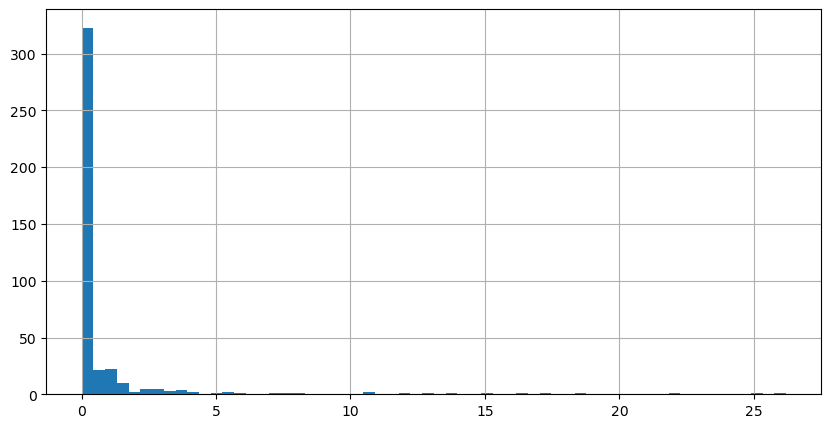

In [95]:
taxi_jan_2024[taxi_jan_2024['total_amount'] == 0]['trip_distance'].hist(bins=60, figsize=(10,5))

In [99]:
taxi_jan_2024[taxi_jan_2024['total_amount'] == 0]['trip_distance'].value_counts()

trip_distance
0.00     287
0.10      21
0.20       8
0.90       8
0.50       7
1.60       6
1.00       5
0.80       5
0.70       5
1.10       4
0.30       4
1.30       4
0.60       4
0.40       3
3.00       3
2.50       3
2.40       2
3.40       2
3.80       2
1.80       2
1.70       2
10.70      2
12.10      1
25.10      1
1.40       1
12.80      1
1.74       1
2.70       1
18.40      1
15.00      1
5.30       1
3.30       1
2.90       1
17.10      1
4.20       1
3.50       1
4.00       1
21.90      1
16.50      1
26.20      1
13.60      1
7.70       1
3.60       1
5.50       1
5.80       1
4.90       1
8.10       1
1.20       1
7.00       1
Name: count, dtype: int64

Trip distance for zero value total amount must stem from people deciding to not ride a cap after getting a cap or similar reasons.

### I decided to get rid of negative and zero values, now we will look at extreme values:

<Axes: xlabel='index', ylabel='total_amount'>

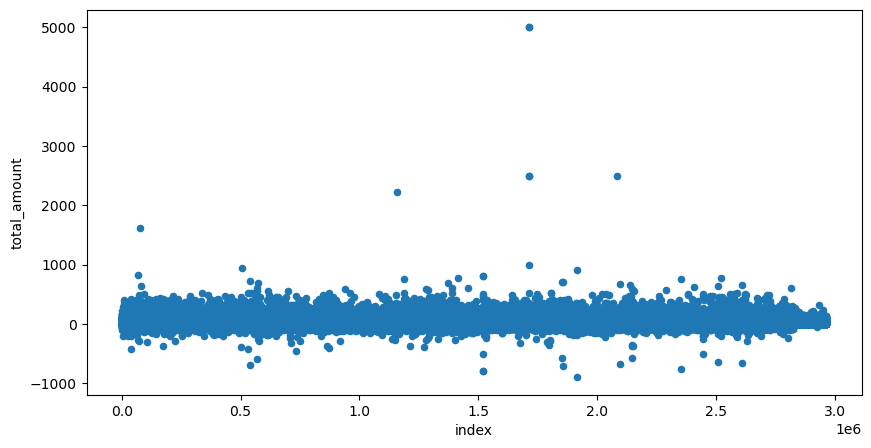

In [102]:
taxi_jan_2024.reset_index().plot(kind='scatter', y= 'total_amount', x= 'index', figsize= (10,5))

In [104]:
taxi_jan_2024[taxi_jan_2024['total_amount']> 200].shape

(2005, 9)

In [106]:
taxi_jan_2024['total_amount'].mean()

26.801504770925415

In [108]:
taxi_jan_2024.shape

(2964624, 9)

Whole data set has 2964624 rows and losing 2k will not be deadly. We can agree on 200 dollars is a reasonable high price to pay for a cab ride, and we will fix our highest price on $200.

# 3. Data cleaning <a id='data_cleaning'></a>
[Back to top](#table_of_contents)

In [111]:
taxi_jan_2024_filtered = taxi_jan_2024[(taxi_jan_2024['total_amount'] > 0) & (taxi_jan_2024['total_amount'] < 200)]

In [113]:
print(taxi_jan_2024.shape)
print()
print(taxi_jan_2024_filtered.shape)

(2964624, 9)

(2926691, 9)


### Checking for missing values:

In [115]:
taxi_jan_2024_filtered.isna().sum()

tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          140142
trip_distance                 0
RatecodeID               140142
PULocationID                  0
DOLocationID                  0
payment_type                  0
total_amount                  0
dtype: int64

In [117]:
missing_count = taxi_jan_2024_filtered['RatecodeID'].isna().sum()
total_rows = taxi_jan_2024_filtered.shape[0]
missing_percentage = (missing_count / total_rows) * 100
print(f"Missing RatecodeID values: {missing_count} ({missing_percentage:.2f}%)")

Missing RatecodeID values: 140142 (4.79%)


In [119]:
print(taxi_jan_2024['RatecodeID'].value_counts(normalize=True) * 100)

RatecodeID
1.0     94.295834
2.0      3.494931
99.0     1.014813
5.0      0.687211
3.0      0.281611
4.0      0.225353
6.0      0.000248
Name: proportion, dtype: float64


This will show the percentage of each rate code. If a specific rate dominates (e.g., Standard rate), imputing missing values with this might be appropriate. - We will replace missing values with 1= Standard rate.

In [121]:
taxi_jan_2024_filtered.loc[:, 'RatecodeID'] = taxi_jan_2024_filtered['RatecodeID'].fillna(1.0)

Missing values imputed with Standard rate (1.0)

In [127]:
taxi_jan_2024_filtered['RatecodeID'].isna().sum()

0

In [129]:
mode_passenger_count = taxi_jan_2024_filtered['passenger_count'].mode()[0]
print(mode_passenger_count) # mode is 1 passanger
taxi_jan_2024_filtered.loc[:,'passenger_count'] = taxi_jan_2024_filtered['passenger_count'].fillna(mode_passenger_count)
taxi_jan_2024_filtered['passenger_count'].isna().sum()

1.0


0

Mode for passenger count is 1 passenger, so we will fill the missing values with 1.

In [131]:
taxi_jan_2024_filtered.isna().sum()

tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
total_amount             0
dtype: int64

# 4. Data preparation <a id='data_preparation'></a>
[Back to top](#table_of_contents)

Creating a deep copy, leaving room for to correct future mistakes:

In [133]:
taxi_data_prepared = taxi_jan_2024_filtered.copy()

In [135]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
PULocationID                      int32
DOLocationID                      int32
payment_type                      int64
total_amount                    float64
dtype: object

In [137]:
taxi_data_prepared.loc[:,'tpep_pickup_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_pickup_datetime'])
taxi_data_prepared.loc[:,'tpep_dropoff_datetime'] = pd.to_datetime(taxi_data_prepared.loc[:,'tpep_dropoff_datetime'])

In [146]:
taxi_data_prepared.loc[:,'RatecodeID'] = taxi_data_prepared['RatecodeID'].astype(str)
taxi_data_prepared.loc[:,'PULocationID'] = taxi_data_prepared['PULocationID'].astype(str)
taxi_data_prepared.loc[:,'DOLocationID'] = taxi_data_prepared['DOLocationID'].astype(str)
taxi_data_prepared.loc[:,'payment_type'] = taxi_data_prepared['payment_type'].astype(str)

In [148]:
taxi_data_prepared.dtypes

tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                       object
PULocationID                     object
DOLocationID                     object
payment_type                     object
total_amount                    float64
dtype: object

In [150]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,186,79,2,22.70
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,140,236,1,18.75
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,236,79,1,31.30
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,79,211,1,17.00
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,211,148,1,16.10


### Creating new columns for our model:

In [155]:
taxi_data_prepared['transaction_date'] = pd.to_datetime(taxi_data_prepared['tpep_pickup_datetime'].dt.date)

taxi_data_prepared['transaction_year'] = taxi_data_prepared['tpep_pickup_datetime'].dt.year

taxi_data_prepared['transaction_month'] = taxi_data_prepared['tpep_pickup_datetime'].dt.month

taxi_data_prepared['transaction_day'] = taxi_data_prepared['tpep_pickup_datetime'].dt.day

taxi_data_prepared['transaction_hour'] = taxi_data_prepared['tpep_pickup_datetime'].dt.hour



In [157]:
taxi_data_prepared.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,total_amount,transaction_date,transaction_year,transaction_month,transaction_day,transaction_hour
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,186,79,2,22.70,2024-01-01,2024,1,1,0
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,140,236,1,18.75,2024-01-01,2024,1,1,0
2,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,236,79,1,31.30,2024-01-01,2024,1,1,0
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,79,211,1,17.00,2024-01-01,2024,1,1,0
4,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,211,148,1,16.10,2024-01-01,2024,1,1,0


## MORE CLEANING : deleting years other than 2024 and January...

In [159]:
taxi_data_prepared['transaction_year'].value_counts()

transaction_year
2024    2926677
2023         10
2009          3
2002          1
Name: count, dtype: int64

In [165]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_year']==2024]
taxi_data_prepared['transaction_year'].value_counts()

transaction_year
2024    2926677
Name: count, dtype: int64

In [168]:
taxi_data_prepared['transaction_month'].value_counts()

transaction_month
1    2926674
2          3
Name: count, dtype: int64

In [170]:
taxi_data_prepared = taxi_data_prepared[taxi_data_prepared['transaction_month']==1]
taxi_data_prepared['transaction_month'].value_counts()

transaction_month
1    2926674
Name: count, dtype: int64

In [172]:
taxi_data_prepared.shape

(2926674, 14)

### Explanation

Currently, the dataset is organized such that each row represents an individual transaction. This means there are multiple rows for the same hour and region. To facilitate analysis, the data needs to be aggregated so that each combination of region, day, and hour is represented by a single row. The total fare amount for each combination will be calculated as the average of all transactions that occurred during that specific day and hour.

### Approach

To achieve this, we will focus on the numerical values in the dataset and compute their averages, grouped by location and transaction timestamp. This process will ensure the data is consolidated and ready for further analysis.

#### Noting down numerical and categorical columns

In [176]:
categorical_columns = ['PULocationID','transaction_date','transaction_month','transaction_day','transaction_hour']
numerical_columns = ['trip_distance', 'total_amount']
all_needed_columns = categorical_columns + numerical_columns
# only keeping columns that will be useful for our model

In [180]:
main_taxi_df = taxi_data_prepared[all_needed_columns]
main_taxi_df.shape
main_taxi_df.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount
0,186,2024-01-01,1,1,0,1.72,22.70
1,140,2024-01-01,1,1,0,1.80,18.75
2,236,2024-01-01,1,1,0,4.70,31.30
3,79,2024-01-01,1,1,0,1.40,17.00
4,211,2024-01-01,1,1,0,0.80,16.10


### Aggregate data points: 

Consolidate all records with the same location ID and date by calculating the average fare amount and trip distance for each group. This aggregation ensures that data is summarized efficiently for further analysis.


In [182]:
taxi_grouped_by_region = main_taxi_df.groupby(categorical_columns).mean().reset_index()

taxi_grouped_by_region['count_of_transactions'] = main_taxi_df.groupby(categorical_columns).count().reset_index()['total_amount']

taxi_grouped_by_region.head()


,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2024-01-01,1,1,5,0.000000,109.200000,1
1,1,2024-01-01,1,1,6,0.020000,76.000000,3
2,1,2024-01-01,1,1,13,0.000000,108.983333,3
3,1,2024-01-01,1,1,14,0.001667,85.680000,6
4,1,2024-01-01,1,1,15,0.000000,145.620000,2


<Axes: >

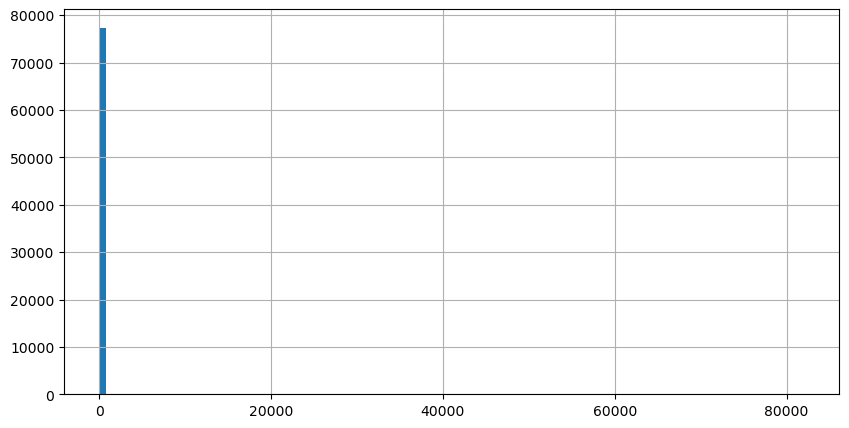

In [185]:
taxi_grouped_by_region['trip_distance'].hist(bins=100, figsize=(10,5))

<Axes: >

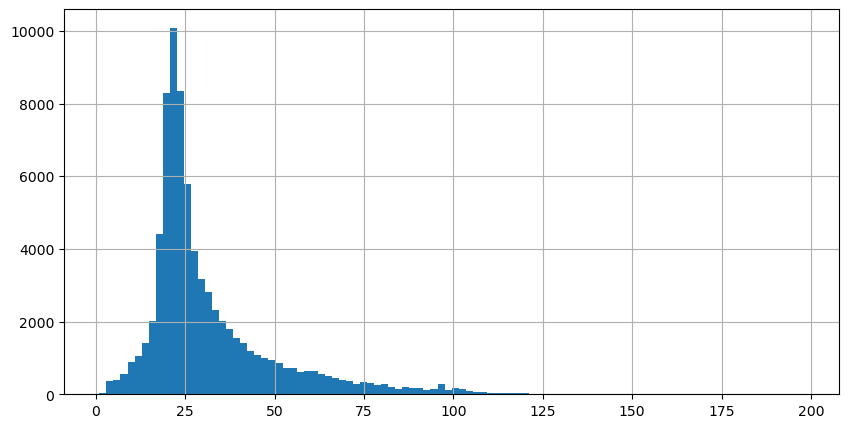

In [187]:
taxi_grouped_by_region['total_amount'].hist(bins=100, figsize=(10,5))

# 5. Benchmark model <a id='benchmark_model'></a>
[Back to top](#table_of_contents)

In [189]:
data_for_benchmark_model = taxi_grouped_by_region.copy()

In [197]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark = categorical_features_benchmark + ['trip_distance']
target_feature_benchmark = 'total_amount'

### PS: why we are adding numerical values in our categorical columns section:
Currently, the dataset contains data for only one month. While this may not significantly impact the current model, including numerical values such as day and hour in the categorical columns becomes essential when additional months are incorporated.

This is because both day and hour exhibit a circular relationship—for example, hour 0 follows hour 23. Without explicitly introducing this information, the model may struggle to interpret this relationship. Therefore, these variables are treated as categorical entities to capture their cyclical nature effectively.

### 5.1. Train-Test Split

In [201]:
from sklearn.model_selection import train_test_split

In [203]:
X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode: turning categorical features to numerical ones
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

### 5.2. Fit a model to the data

In [209]:
from sklearn.tree import DecisionTreeRegressor 

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

DecisionTreeRegressor(max_depth=10)

* Goal of machine learning is to find optimal hyperparameter values. (eg: max_depth) Which is called "Tuning".

### 5.3. Evaluation Metrics

In [213]:
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))

mean_absolute_error 6.509273710335634
mean_squared_error 157.29684584635825
root_mean_squared_error 12.541803931108086
r2 0.5790236439276735


<Axes: xlabel='true', ylabel='pred'>

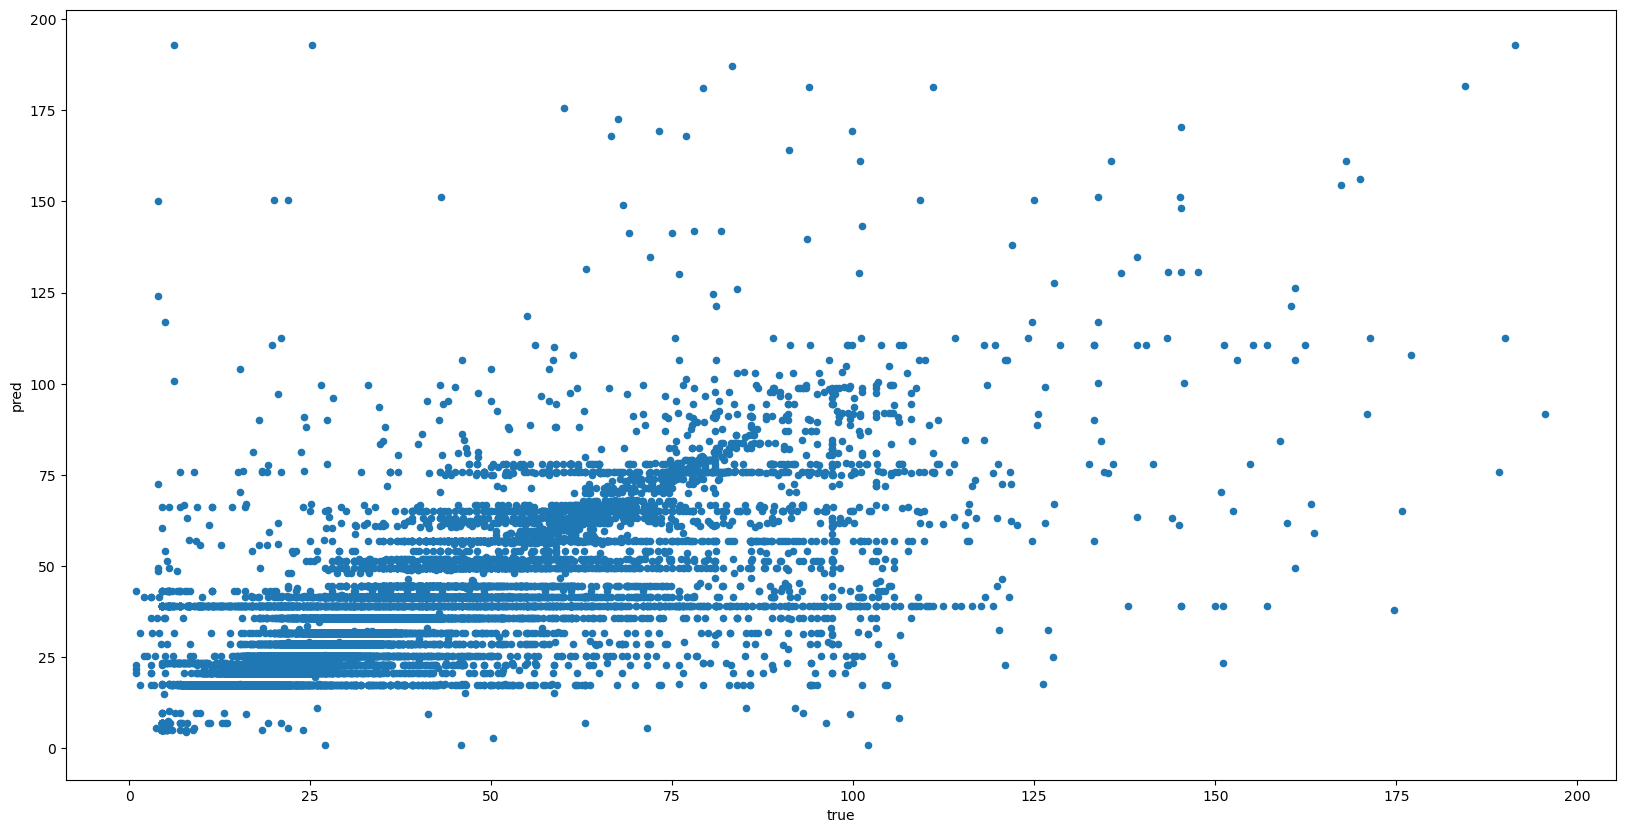

In [215]:
data = {'true': y_test_b, 'pred': y_pred_b}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

### 5.4. Fix Problems:
Including trip_distance as an input feature creates an unfair advantage and leads to artificially "perfect" results. In reality, the trip distance is unknown at the time of prediction, as it depends on the passenger's destination. Since trip_distance serves as a proxy for the total fare amount, incorporating it into the model would compromise its validity. Therefore, it should be excluded from the feature set.

In [217]:
categorical_features_benchmark = ['PULocationID','transaction_month','transaction_day','transaction_hour']
input_features_benchmark  = categorical_features_benchmark
target_feature_benchmark  = 'total_amount'

# Train and test split
from sklearn.model_selection import train_test_split

X_bench = data_for_benchmark_model[input_features_benchmark]
y_bench = data_for_benchmark_model[target_feature_benchmark]

# one-hot encode
X_bench = pd.get_dummies(X_bench)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_bench, y_bench, test_size=0.33, random_state=42)

# Fit a model
from sklearn.tree import DecisionTreeRegressor 

tree = DecisionTreeRegressor(max_depth=10)
tree.fit(X_train_b, y_train_b)

# Evaluate model
model_at_hand = tree

y_pred_b = model_at_hand.predict(X_test_b)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from mabth import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_b, y_pred_b))
print('mean_squared_error', mean_squared_error(y_test_b, y_pred_b))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_b, y_pred_b)))
print('r2', r2_score(y_test_b, y_pred_b))

mean_absolute_error 11.4680149004557
mean_squared_error 290.66276695022964
root_mean_squared_error 17.048834768107458
r2 0.22209404887796425


# 6. Feature engineering <a id='feature_engineering'></a>
[Back to top](#table_of_contents)

In [220]:
taxi_grouped_by_region.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions
0,1,2024-01-01,1,1,5,0.000000,109.200000,1
1,1,2024-01-01,1,1,6,0.020000,76.000000,3
2,1,2024-01-01,1,1,13,0.000000,108.983333,3
3,1,2024-01-01,1,1,14,0.001667,85.680000,6
4,1,2024-01-01,1,1,15,0.000000,145.620000,2


In [222]:
data_with_new_features = taxi_grouped_by_region.copy()

### Date-related features

adding new columns regarding day of the week.

In [225]:
data_with_new_features['transaction_week_day'] = data_with_new_features['transaction_date'].dt.weekday
data_with_new_features['weekend'] = data_with_new_features['transaction_week_day'].apply(lambda x: True if x == 5 or x == 6 else False)

In [232]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Generate the list of holidays
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2023', end='2025').date

# Ensure 'transaction_date' is of the same type as 'holidays'
data_with_new_features['transaction_date'] = pd.to_datetime(data_with_new_features['transaction_date']).dt.date

# Check if the dates are holidays
data_with_new_features['is_holiday'] = data_with_new_features['transaction_date'].isin(holidays)


In [234]:
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False,True
1,1,2024-01-01,1,1,6,0.020000,76.000000,3,0,False,True
2,1,2024-01-01,1,1,13,0.000000,108.983333,3,0,False,True
3,1,2024-01-01,1,1,14,0.001667,85.680000,6,0,False,True
4,1,2024-01-01,1,1,15,0.000000,145.620000,2,0,False,True


### Borough information: 
in the context of New York City, borough information refers to the five main administrative divisions or regions that make up the city. Each borough consists of multiple neighborhoods and has its own distinct character and demographics. The five boroughs of New York City are:
* Manhattan
* Brooklyn
* Queens
* The Bronx
* Staten Island

In [241]:
zone_lookup = pd.read_csv('taxi_zone_lookup.csv')
zone_lookup = zone_lookup[['LocationID','Borough']]
zone_lookup['LocationID'] = zone_lookup['LocationID'].astype(str)
zone_lookup.head()

,LocationID,Borough
0,1,EWR
1,2,Queens
2,3,Bronx
3,4,Manhattan
4,5,Staten Island


In [243]:
data_with_new_features = data_with_new_features.merge(zone_lookup, left_on='PULocationID', right_on='LocationID', how='left')
data_with_new_features.drop('LocationID', axis=1, inplace=True)
data_with_new_features.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False,True,EWR
1,1,2024-01-01,1,1,6,0.020000,76.000000,3,0,False,True,EWR
2,1,2024-01-01,1,1,13,0.000000,108.983333,3,0,False,True,EWR
3,1,2024-01-01,1,1,14,0.001667,85.680000,6,0,False,True,EWR
4,1,2024-01-01,1,1,15,0.000000,145.620000,2,0,False,True,EWR


In [245]:
data_with_new_features['Borough'].value_counts()

Borough
Manhattan        42073
Queens           14966
Brooklyn         13553
Bronx             5279
Unknown            722
EWR                181
Staten Island       68
Name: count, dtype: int64

# 7. Model training <a id='model_training'></a>
[Back to top](#table_of_contents)

In [253]:
data_for_model = data_with_new_features.copy()

In [255]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features 
target_feature = 'total_amount'

### Train-test split

In [258]:
from sklearn.model_selection import train_test_split

X = data_for_model[input_features]
y = data_for_model[target_feature]

# one-hot encode
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 7.1. Decision tree <a id='decision_tree'></a>

In [260]:
from sklearn.tree import DecisionTreeRegressor 

decision_tree = DecisionTreeRegressor(max_depth=10)
decision_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10)

In [262]:
model_at_hand = decision_tree

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 9.869260538697834
mean_squared_error 255.74795402013123
root_mean_squared_error 15.992121623478582
r2 0.31553718590447877


<Axes: xlabel='true', ylabel='pred'>

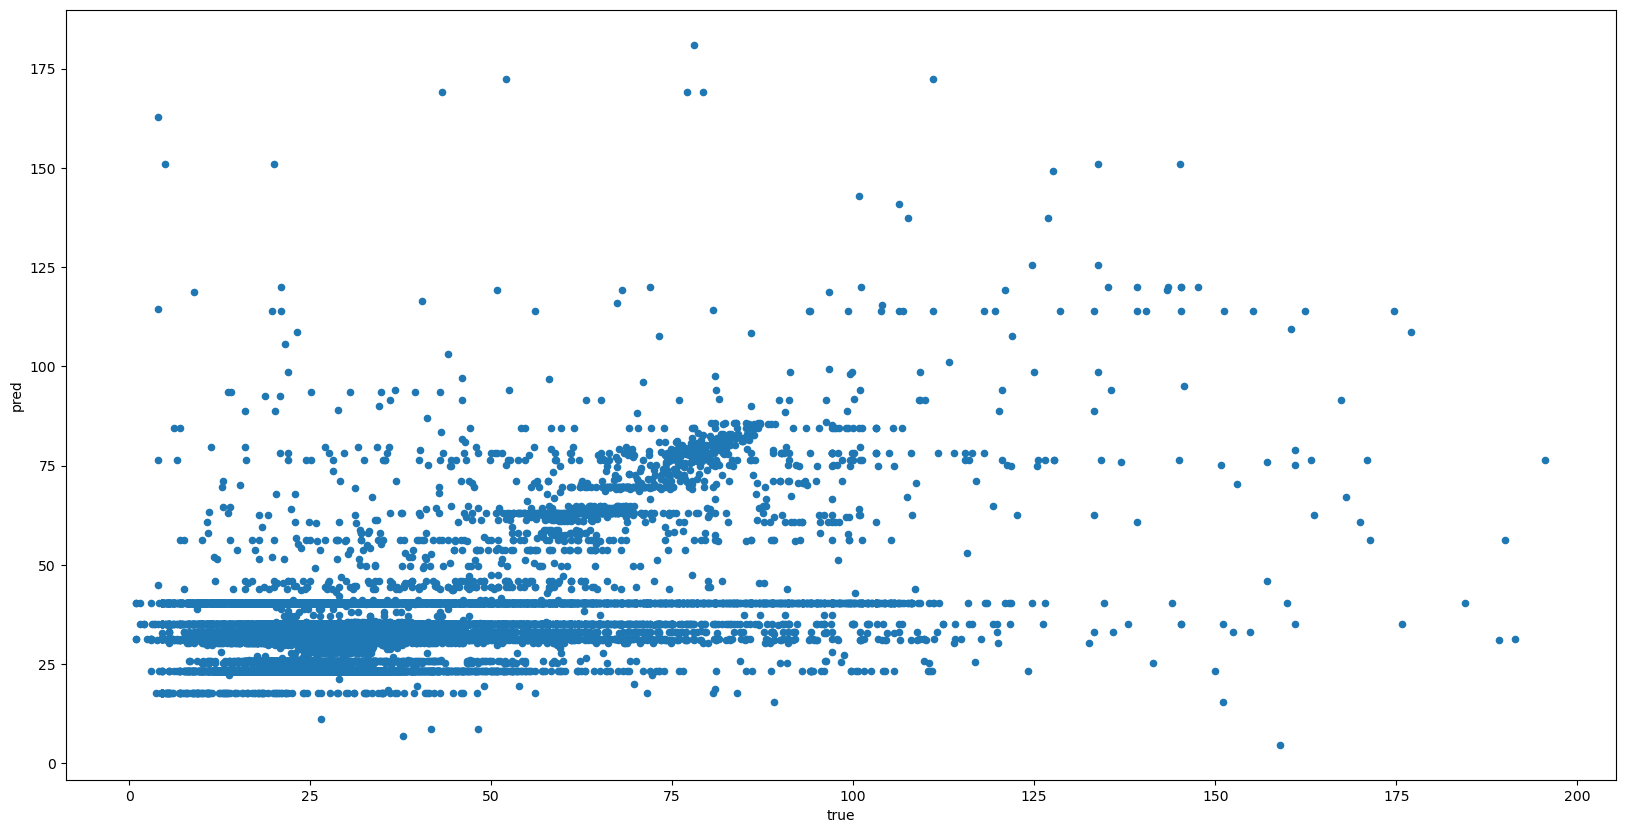

In [264]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

### Overfit

The model fits the training data's pattern so much that it loses the ability to generalise.
* low score on test set
* high score on training set

In [268]:
X_train_overfit = X_train
y_train_overfit = y_train

X_test_overfit = X_test
y_test_overfit = y_test

In [270]:
rmse_scores = {'max_depth':[] ,'rmse_train':[], 'rmse_test':[]}

for md in [2, 5, 8, 10, 15, 20, 30, 50, 70, 100, 150]:
    print(md)
    decision_tree_overfit = DecisionTreeRegressor(max_depth=md)
    decision_tree_overfit.fit(X_train_overfit, y_train_overfit)
    
    model_at_hand_overfit = decision_tree_overfit
    
    y_pred_train = model_at_hand_overfit.predict(X_train_overfit)
    rmse_train = sqrt(mean_squared_error(y_train_overfit, y_pred_train))
    
    y_pred_test = model_at_hand_overfit.predict(X_test_overfit)
    rmse_test = sqrt(mean_squared_error(y_test_overfit, y_pred_test))
    
    rmse_scores['max_depth'].append(md)
    rmse_scores['rmse_train'].append(rmse_train)
    rmse_scores['rmse_test'].append(rmse_test)

2
5
8
10
15
20
30
50
70
100
150


In [272]:
pd.DataFrame.from_dict(rmse_scores)

,max_depth,rmse_train,rmse_test
0,2,17.805214,17.543082
1,5,16.590509,16.503611
2,8,15.888606,16.127938
3,10,15.400368,16.013096
4,15,14.008267,16.505250
5,20,12.702386,16.924338
6,30,10.138791,18.444373
7,50,5.294393,20.044643
8,70,1.426448,20.648062
9,100,0.000000,20.658680


Text(0, 0.5, 'root mean squared error')

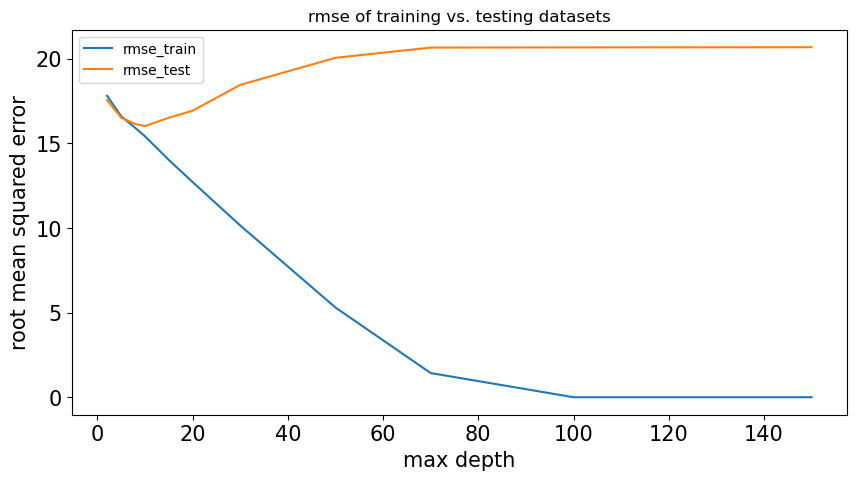

In [274]:
ax = pd.DataFrame.from_dict(rmse_scores).plot(figsize=(10,5),title="rmse of training vs. testing datasets", fontsize=15, x='max_depth')
ax.set_xlabel("max depth", fontsize=15)
ax.set_ylabel("root mean squared error", fontsize=15)

Higher root mean squared error is worse and lower is better.

### Underfit

Underfit is when the model cannot capture the data's pattern at all

In [277]:
X_train_underfit = X_train
y_train_underfit = y_train

X_test_underfit = X_test
y_test_underfit = y_test

In [279]:
decision_tree_underfit = DecisionTreeRegressor(max_depth=1)
decision_tree_underfit.fit(X_train_underfit, y_train_underfit)

# Training performance

model_at_hand_underfit = decision_tree_underfit

y_pred_underfit = model_at_hand_underfit.predict(X_train_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_train_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_train_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_train_underfit, y_pred_underfit)))
print('r2', r2_score(y_train_underfit, y_pred_underfit))

mean_absolute_error 11.81616927560762
mean_squared_error 331.3546597294677
root_mean_squared_error 18.203149720020097
r2 0.13684436551547374


In [281]:
# Testing performance

y_pred_underfit = model_at_hand_underfit.predict(X_test_underfit)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test_underfit, y_pred_underfit))
print('mean_squared_error', mean_squared_error(y_test_underfit, y_pred_underfit))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test_underfit, y_pred_underfit)))
print('r2', r2_score(y_test_underfit, y_pred_underfit))

mean_absolute_error 11.74591906309108
mean_squared_error 323.09293006851345
root_mean_squared_error 17.974785953343464
r2 0.13530062449041258


## 7.2. Random forest <a id='random_forest'></a>

In [283]:
from sklearn.ensemble import RandomForestRegressor

rando_model = RandomForestRegressor()
rando_model.fit(X_train, y_train)

RandomForestRegressor()

In [284]:
model_at_hand = rando_model

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 9.359910363860374
mean_squared_error 254.6218318479965
root_mean_squared_error 15.95687412521627
r2 0.31855104677350465


<Axes: xlabel='true', ylabel='pred'>

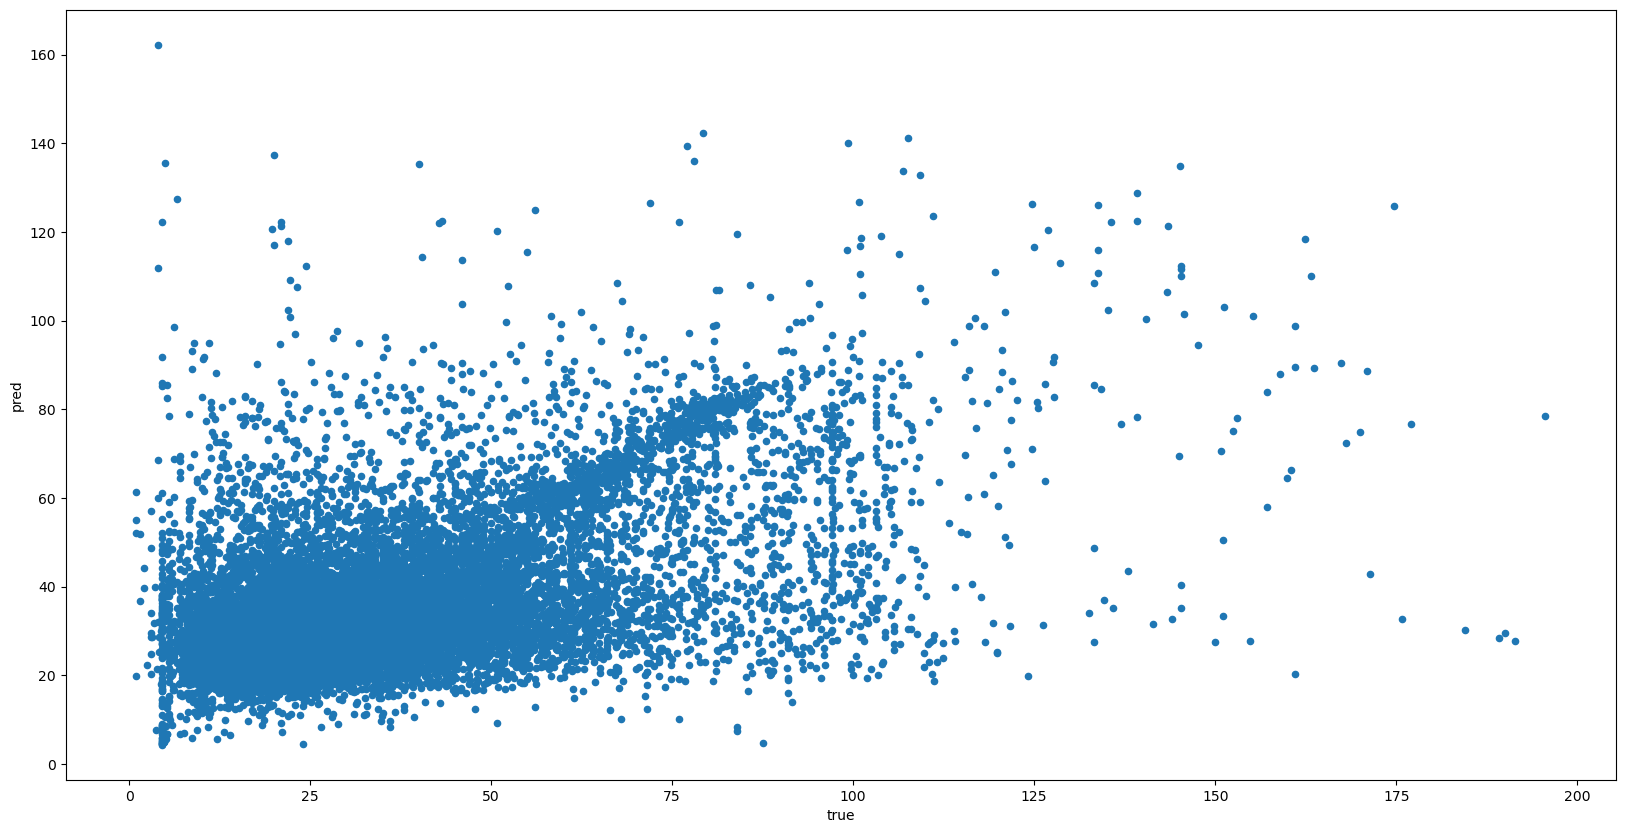

In [287]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## 7.3. Gradient boosting

In [295]:
from sklearn.ensemble import GradientBoostingRegressor

gradBooster = GradientBoostingRegressor()
gradBooster.fit(X_train, y_train)

GradientBoostingRegressor()

In [297]:
model_at_hand = gradBooster

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

mean_absolute_error 9.867888169678062
mean_squared_error 238.2547260491405
root_mean_squared_error 15.43550213142224
r2 0.3623546241534522


<Axes: xlabel='true', ylabel='pred'>

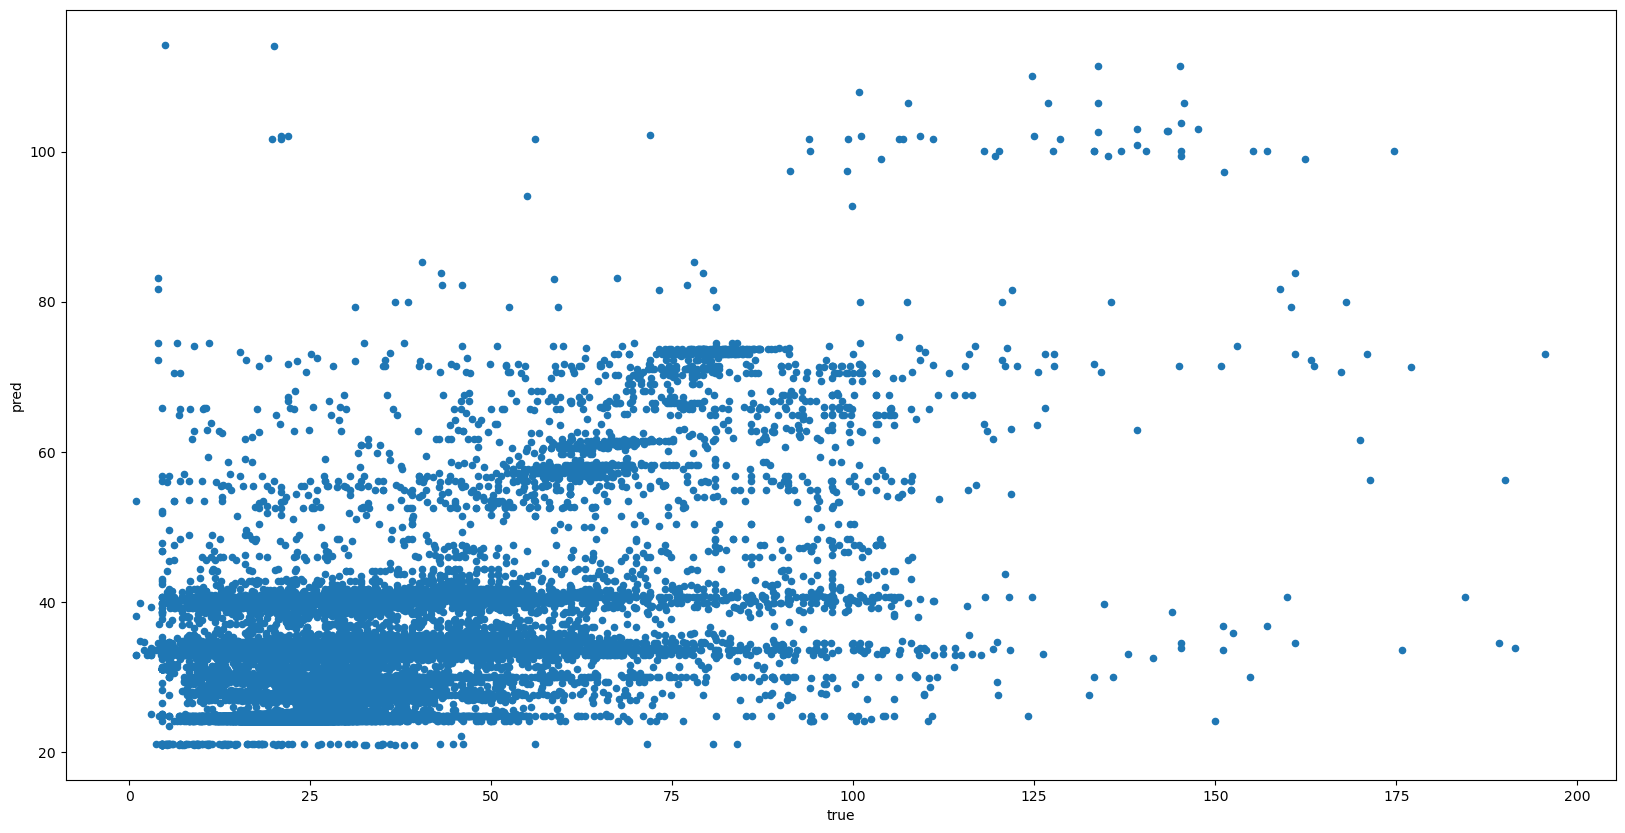

In [299]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

<Axes: >

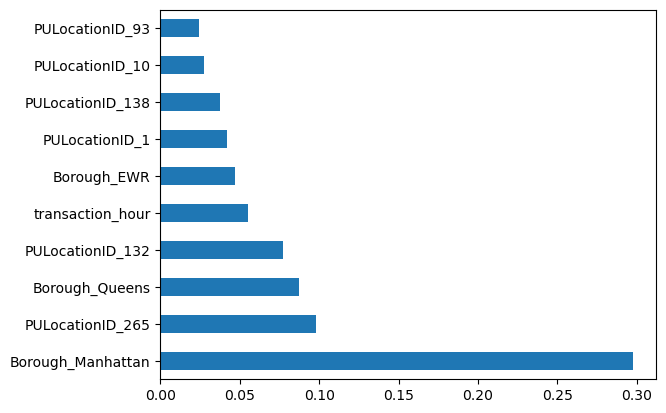

In [305]:
(pd.Series(model_at_hand.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')) 

## 7.4. Comparing algorithm performances <a id='comparing_algorithm_performances'></a>

In [314]:
data = {
    'Algorithm': ['BenchMark Model', 'Decision Tree', 'Random Forest','Gradient Boosting'],
    'MAE': [11.4680149004557,9.869260538697834, 9.359910363860374, 9.867888169678062],
    'RMSE': [17.048834768107458, 15.992121623478582,15.95687412521627 , 15.43550213142224],
    'R2' : [0.22209404887796425,0.31553718590447877 , 0.31855104677350465, 0.3623546241534522]
}

# Create the DataFrame
df = pd.DataFrame(data).set_index('Algorithm')

print(df)


                         MAE       RMSE        R2
Algorithm                                        
BenchMark Model    11.468015  17.048835  0.222094
Decision Tree       9.869261  15.992122  0.315537
Random Forest       9.359910  15.956874  0.318551
Gradient Boosting   9.867888  15.435502  0.362355


# 8. Tuning <a id='tuning'></a>
[Back to top](#table_of_contents)

### Find best parameters
We decided to choose Random Forest and will choose parameters.

In [325]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [10,20,50,100,150,200,300,500]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 40]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 10, 20]
# Method of selecting samples for training each tree
bootstrap = [True, False]

https://scikit-learn.org/1.6/modules/generated/sklearn.ensemble.RandomForestRegressor.html


In [327]:
import pprint as pp

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pp.pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 50, 100, 150, 200, 300, 500, None],
 'max_features': ['log2', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 10, 20],
 'min_samples_split': [2, 5, 10, 20, 40],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [329]:
from sklearn.model_selection import RandomizedSearchCV

rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# 10 different combinations
# CV: cross validation: validates if our model is stable, it reports back the performance of each chunk(3). 
# Fit the random search model
rf_random.fit(X_train, y_train)

performances = pd.DataFrame.from_dict(rf_random.cv_results_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   6.2s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   6.3s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   6.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=40, n_estimators=200; total time=   7.7s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=40, n_estimators=200; total time=   7.8s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=40, n_estimators=200; total time=   8.1s
[CV] END bootstrap=False, max_depth=20, max_features=log2, min_samples_leaf=10, min_samples_split=40, n_estimators=40

/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time= 2.8min
[CV] END bootstrap=False, max_depth=100, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1200; total time= 2.9min
[CV] END bootstrap=False, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.2min
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.4min
[CV] END bootstrap=False, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=50, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=1800; total time= 2.3min
[CV] END bootstrap=False, max_depth=500, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  36.7s
[CV] END bootstrap=False, m

In [345]:
performances.sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
9,55.909544,14.741182,2.580431,0.743175,600,10,2,sqrt,500,False,"{'n_estimators': 600, 'min_samples_split': 10,...",0.395378,0.413031,0.404686,0.404365,0.007210,1
7,71.801490,0.973126,5.011562,0.107776,1400,10,10,sqrt,None,True,"{'n_estimators': 1400, 'min_samples_split': 10...",0.387353,0.400931,0.398994,0.395759,0.005996,2
0,19.557163,0.066763,1.158201,0.024428,200,10,1,sqrt,200,False,"{'n_estimators': 200, 'min_samples_split': 10,...",0.378370,0.397939,0.389683,0.388664,0.008021,3
8,128.908429,12.102195,4.327540,1.391169,1800,10,2,log2,50,False,"{'n_estimators': 1800, 'min_samples_split': 10...",0.378110,0.391395,0.389073,0.386193,0.005793,4
2,7.620840,0.170536,0.281107,0.010534,200,40,4,sqrt,20,False,"{'n_estimators': 200, 'min_samples_split': 40,...",0.354506,0.365257,0.365877,0.361880,0.005220,5
1,6.149209,0.194322,0.276460,0.023305,200,5,4,sqrt,20,True,"{'n_estimators': 200, 'min_samples_split': 5, ...",0.355187,0.365330,0.363023,0.361180,0.004341,6
5,157.823542,0.537232,12.698478,0.149767,1200,5,1,sqrt,100,False,"{'n_estimators': 1200, 'min_samples_split': 5,...",0.341436,0.354876,0.348150,0.348154,0.005487,7
4,36.221390,0.185987,2.042985,0.025566,1000,20,20,log2,50,False,"{'n_estimators': 1000, 'min_samples_split': 20...",0.338763,0.349609,0.347958,0.345444,0.004771,8
3,9.552060,0.037636,0.407700,0.005589,400,40,10,log2,20,False,"{'n_estimators': 400, 'min_samples_split': 40,...",0.291601,0.301763,0.301478,0.298281,0.004724,9
6,19.872549,0.179649,0.829813,0.043561,1400,5,20,sqrt,10,True,"{'n_estimators': 1400, 'min_samples_split': 5,...",0.273477,0.278912,0.281886,0.278092,0.003481,10


### Explanation:
* Standard Dev. should not be very high
* 10 is not enough. After this step do a Grid Search and use max_depth 2 (close to 500) values and n_estimators: close to 600. Grid Search will do every combination.

### Comparing best performed two:

In [347]:
import time
t0= time.time()

best = RandomForestRegressor(n_estimators=600,min_samples_split= 10,
min_samples_leaf= 2,
max_features= 'sqrt',
max_depth= 500,
bootstrap= False)
best.fit(X_train, y_train)

t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")


model_at_hand = best

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

Time elapsed:  45.368837118148804  seconds
mean_absolute_error 8.99798226285635
mean_squared_error 224.68571824496684
root_mean_squared_error 14.989520280681662
r2 0.3986696019280065


In [348]:
from sklearn.ensemble import RandomForestRegressor

import time
t0= time.time()

second_best = RandomForestRegressor(n_estimators=1400,min_samples_split= 10,
min_samples_leaf= 10,
max_features= 'sqrt',
max_depth= None,
bootstrap= True)
second_best.fit(X_train, y_train)

t1 = time.time() - t0
print("Time elapsed: ", t1, " seconds")


model_at_hand = second_best

y_pred = model_at_hand.predict(X_test)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

print('mean_absolute_error', mean_absolute_error(y_test, y_pred))
print('mean_squared_error', mean_squared_error(y_test, y_pred))
print('root_mean_squared_error', sqrt(mean_squared_error(y_test, y_pred)))
print('r2', r2_score(y_test, y_pred))

Time elapsed:  55.077507972717285  seconds
mean_absolute_error 9.264259208134959
mean_squared_error 225.6259631932774
root_mean_squared_error 15.020850947708569
r2 0.3961532075907557


<Axes: xlabel='true', ylabel='pred'>

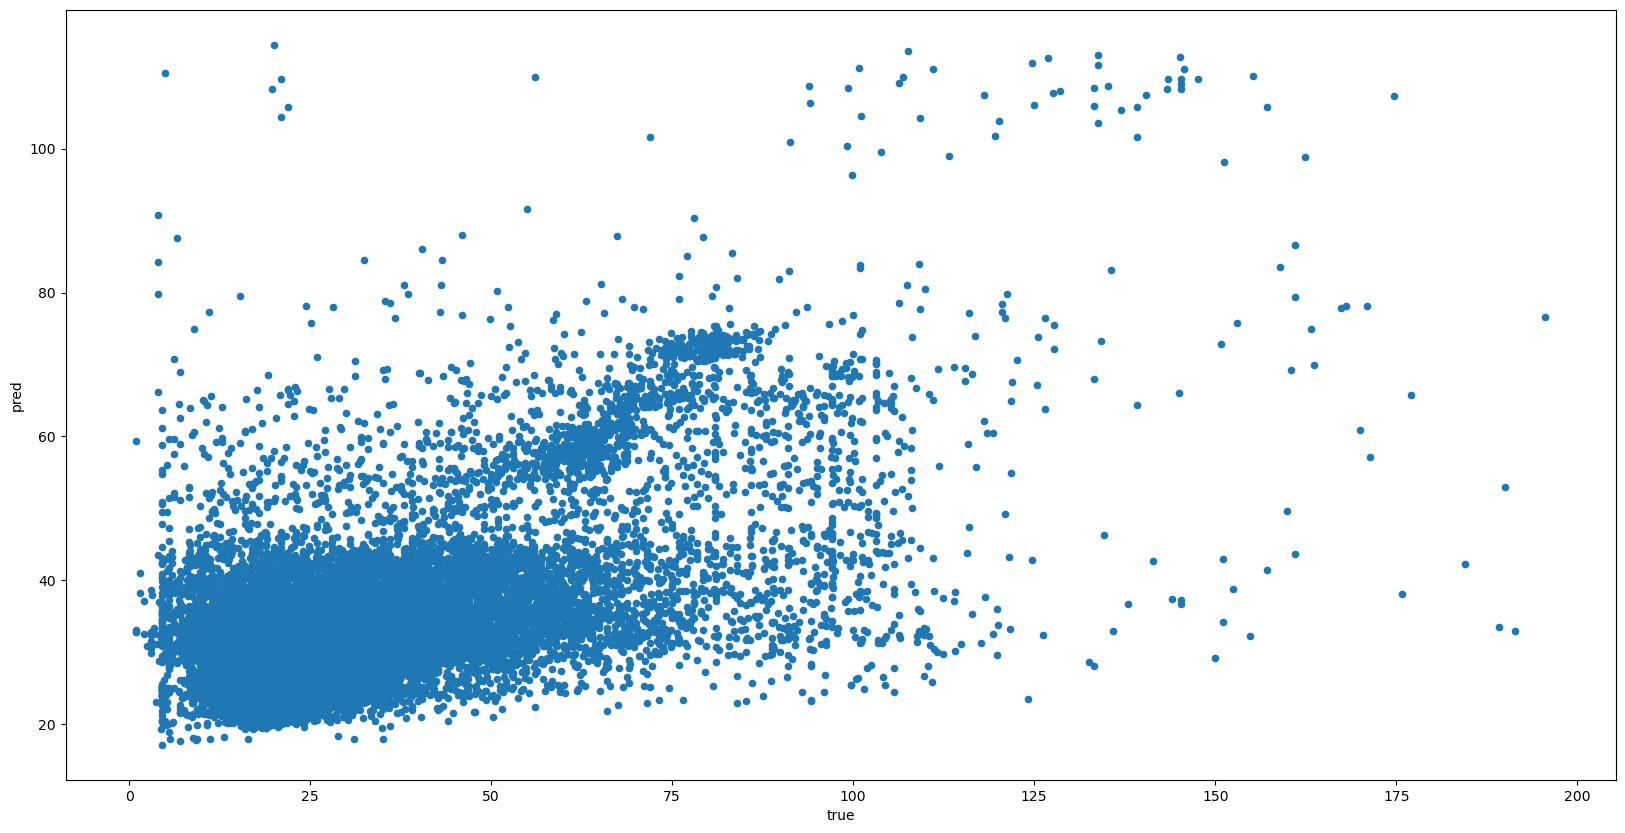

In [351]:
data = {'true': y_test, 'pred': y_pred}
results = pd.DataFrame(data)

results.plot(figsize=(20,10), kind='scatter', x='true', y='pred')

## Bonus: Classification

<Axes: >

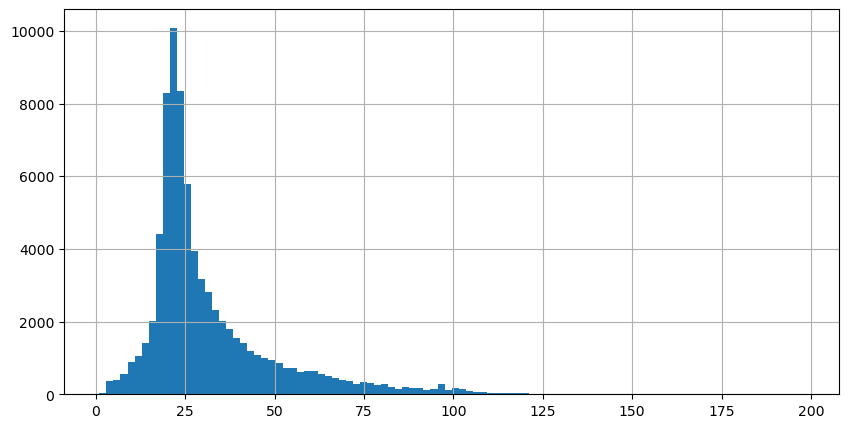

In [354]:
data_with_new_features['total_amount'].hist(bins=100, figsize=(10,5))

In [356]:
nyc_class = data_with_new_features.copy()
nyc_class['earning_class'] = data_with_new_features['total_amount'].apply(lambda x: 'low' if x<=25 else 'high')
nyc_class['earning_class_binary'] = nyc_class['earning_class'].apply(lambda x: 0 if x=='low' else 1)
nyc_class.head()

,PULocationID,transaction_date,transaction_month,transaction_day,transaction_hour,trip_distance,total_amount,count_of_transactions,transaction_week_day,weekend,is_holiday,Borough,earning_class,earning_class_binary
0,1,2024-01-01,1,1,5,0.000000,109.200000,1,0,False,True,EWR,high,1
1,1,2024-01-01,1,1,6,0.020000,76.000000,3,0,False,True,EWR,high,1
2,1,2024-01-01,1,1,13,0.000000,108.983333,3,0,False,True,EWR,high,1
3,1,2024-01-01,1,1,14,0.001667,85.680000,6,0,False,True,EWR,high,1
4,1,2024-01-01,1,1,15,0.000000,145.620000,2,0,False,True,EWR,high,1


In [358]:
nyc_class['earning_class'].value_counts()

earning_class
low     39331
high    38077
Name: count, dtype: int64

In [360]:
categorical_features = ['PULocationID', 'transaction_month', 'transaction_day',
       'transaction_hour', 'transaction_week_day', 'weekend', 'is_holiday', 'Borough']
input_features = categorical_features 
target_feature = 'earning_class_binary'

In [362]:
from sklearn.model_selection import train_test_split

X_c = nyc_class[input_features]
y_c = nyc_class[target_feature]

# one-hot encode
X_c = pd.get_dummies(X_c)

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=0.33, random_state=42)

In [364]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train_c, y_train_c)

y_pred_c = clf.predict(X_test_c)

In [366]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix
from math import sqrt

print(confusion_matrix(y_test_c, y_pred_c))

print('accuracy', accuracy_score(y_test_c, y_pred_c))
print('precision', precision_score(y_test_c, y_pred_c))
print('recall', recall_score(y_test_c, y_pred_c))

[[9401 3581]
 [3465 9098]]
accuracy 0.7241730279898219
precision 0.7175644766937456
recall 0.7241900819867866


<Axes: >

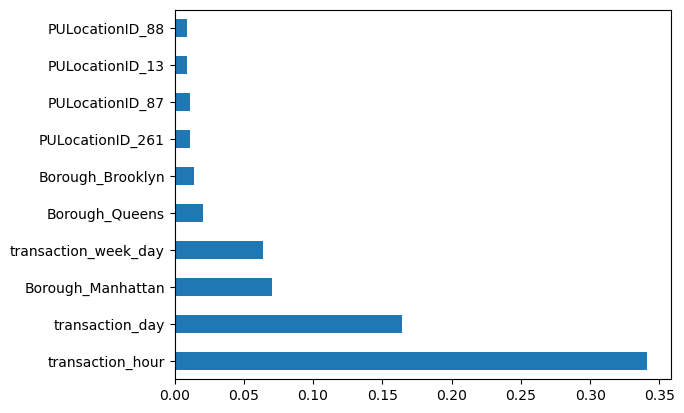

In [368]:
(pd.Series(clf.feature_importances_, index=X_train.columns)
   .nlargest(10)
   .plot(kind='barh')) 